In [1]:
using PBasexInversion
using DelimitedFiles
using PyPlot

## Projection image
In experiments, the photofragments/photoelectrons are propagated into 3D space with a certain velocity. Thus, it looks like a sphere in velocity space; this is called Newton sphere. The Newton sphere is projected onto the detector screen to obtain an image like the one shown below.

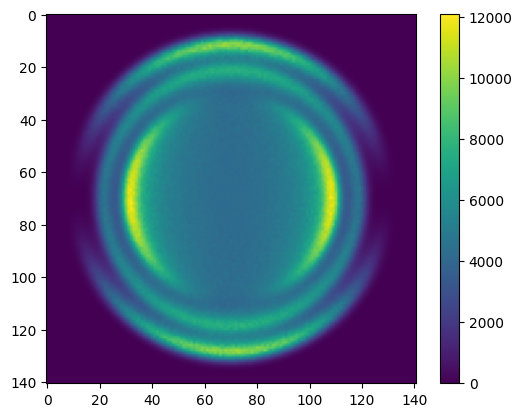

size(img) = (141, 141)


┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\mnkmr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [2]:
# Load a test image
#   Arc1: r = 40 px, σ = 2, β = -1
#   Arc2: r = 50 px, σ = 2, β = 0
#   Arc3: r = 60 px, σ = 2, β = 2
img = readdlm("test\\test02.tsv")
@show size(img)
imshow(img)
colorbar()
;

## Build a reconstructor
The first step is to build a pBasex [1] reconstructor matching with the image size. Each reconstructor has a fixed squre-shaped size. The reconstructing square should cover the projection circle of Newton sphere and be included in the image. For example:

![Image and reconstructor](image/image_and_reconstructor.png)

In the following examples, the reconstructor which size is exactly the same with the image is employed. In this case, the available center coordinate is only the center of image; if the image size is 141x141 then its center is (71, 71). However, in real usage, a reconstructor smaller than the image is also totally OK as far as covering the circle as shown above.

[1] Garcia, G. A.; Nahon L.; Powis I. Two-dimensional charged particle image inversion using a polar basis function expansion, *Rev. Sci. Instrum.*, **2004**, *75*, 4989–4996.

In [3]:
# obtain a reconstructor
pbasex = PBasex(minimum(size(img)))

Computing basis set...100%|█████████████████████████████| Time: 0:00:01


PBasexInversion.PBasex[141×141]: l=[0, 2], σ=2.00

## Reconstruct 3D distributions
The next step is to give the image and its center of projection to reconstruct the 3D distribution. Because pBasex algorithm expects that the Newton sphere is cylindrically symmetric around the laser polarization axis, which is parallel to the vertical axis on an image, therefore the center slice of 3D distribution contains all the information of the distribution.

In [4]:
# reconstruct 3D distribution from an image array (img)
recons = pbasex(img, (71, 71))

  size     : 141 × 141
  intensity: 6.382e+05

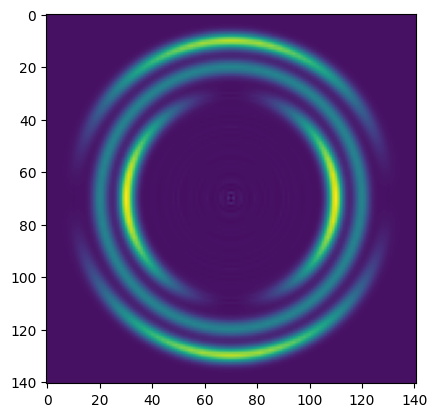

In [5]:
# visualize the center slice of reconstructed distribution
slice = Array(recons)
imshow(slice)
;

## Radial distribution
The radial distribution $I(r)$ is obtained by integrating the 3D photofragment scattering distribution $I(r, \theta)$ all over the solid angles. The scattering distribution does not depend on azimuthal angle $\phi$ since the given 3-D distribution should be cylindrically symmetric.

$$
I(r) = \int_0^{2\pi} \int_0^{\pi} I(r, \theta) r^2 \sin \theta \: d\theta d\phi = 2\pi \int_0^{\pi} I(r, \theta) r^2 \sin \theta \: d\theta
$$

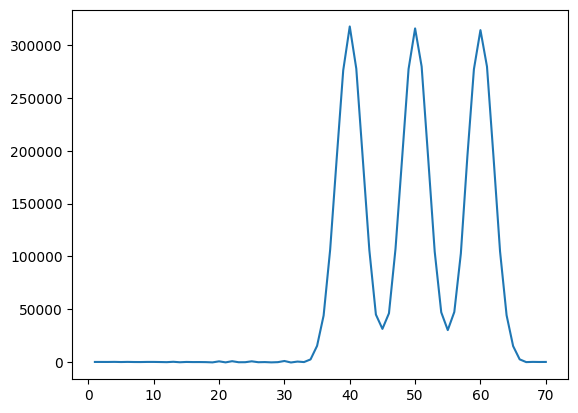

In [6]:
# plot the radial distribution
r, Ir = radialdist(recons)  # r is a vector of radii in pixel unit
plot(r, Ir)
;

## Speed distribution
The radial magnitude of the image is (almost) proportional to the recoiling speed of fragments/electrons. The radial distribution $I(r)$ can be regarded as the number density of particles in a infinitesimal radial range from $r$ to $r+dr$. The number of particles in an infinitesimal range $I(r)dr$ is related to the speed distribution $I^{\prime}(v)$ by an Jacobian term.

$$
I(r) dr = I(r) \frac{dr}{dv} dv = I^{\prime}(v) dv
$$

where

$$
v = \frac{r}{ppm \: N} \frac{1}{t}
$$

$$
\frac{dr}{dv} = (\frac{dv}{dr})^{-1} = t \: ppm \: N
$$

$r$ is the radial distance from the center of projection in pixel unit, $t$ is the time-of-flight in second, $ppm$ is pixel-per-meter ($px/m$) conversion factor, and $N$ is the magnification factor. Eppink-Parker type ion lenses have a kind of lens effect, thus the magnification factor is introduced to compensate the affection. [2] The Jacobian $dr/dv$ does not depend on radius, hence, the radial distribution is simply proportional to the corresponding speed distribution in speed space.

$$
I^{\prime}(v)dv \propto I(r)dv
$$

[2] Eppink, A. T. J. B.; Parker, D. H. Velocity Map Imaging of Ions and Electrons Using Electrostatic Lenses: Application in Photoelectron and Photofragment Ion Imaging of Molecular Oxygen. *Rev. Sci. Instrum.* **1997**, *68*, 3477.

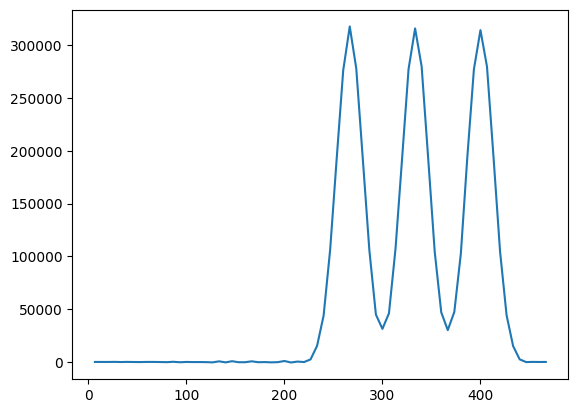

In [7]:
# plot the speed distribution
ppm = 10e3   # pixel-per-meter (px/m)
tof = 10e-6  # time-of-flight in second
N   = 1.5    # magnification factor
v, Iv = speeddist(recons, ppm, tof, N)  # v is a vector of fragment recoil speed in m/s
plot(v, Iv)
;

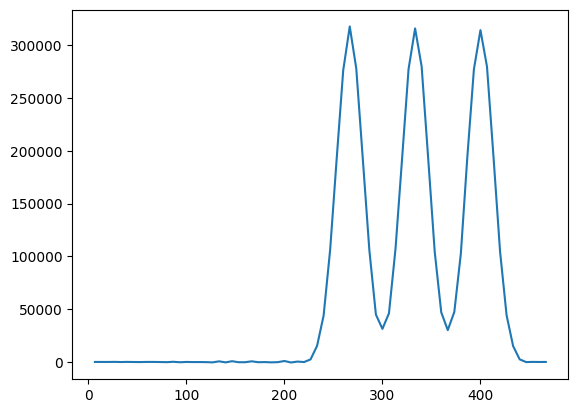

In [8]:
# calculate the speed distribution from the radial distribution
v, Iv = speeddist(r, Ir, ppm, tof, N)  # v is a vector of fragment recoil speed in m/s
plot(v, Iv)
;

## Center-of-mass kinetic energy distribution
Considering the dissociation of a molecule $AB$ into two fragments $A$ and $B$:

$$
AB \rightarrow A + B
$$

In an experiment, the fragment $A$ is observed and its speed distribution $I^{\prime}(v_{A})$ is obtained. The kinetic energy of the fragment $A$ is

$$
E_{A} = \frac{1}{2} m_{A} v_{A}^2
$$

where $m_{A}$ is the mass of fragment $A$. With the above equation, the speed distribution can be converted into the energy distribution $I^{\prime \prime}(E_{A})$.

$$
I^{\prime}(v_{A}) dv_{A} = I^{\prime}(v_{A}) \frac{dv_{A}}{dE_{A}} dE_{A} = I^{\prime \prime}(E_{A}) dE_{A} \\
\frac{dv_{A}}{dE_{A}} = (\frac{dE_{A}}{dv_{A}})^{-1} = \frac{1}{m_{A}v_{A}}
$$

The total kinetic energy release $E_{t}$ is derived from the kinetic energy of a fragment by solving the simultaneous equations of energy and momentum conservations.

$$
\begin{equation}
\begin{cases}
E_{t} = E_{A} + E_{B} = \frac{1}{2} m_{A} v_{A}^2 + \frac{1}{2} m_{B} v_{B}^2 \\
m_{A} v_{A} = m_{B} v_{B}
\end{cases}
\end{equation}
$$

$$
E_{t} = \frac{M}{M - m_{A}} E_{A}
$$

where $M$ is the mass of the parent molecule $M = m_{A} + m_{B}$. Finally, the center-of-mass kinetic energy distribution $I^{\prime \prime \prime}(E_{t})$ is obtained.

$$
I^{\prime \prime}(E_{A}) dE_{A} = I^{\prime \prime}(E_{A}) \frac{dE_{A}}{dE_{t}} dE_{t} = I^{\prime \prime \prime}(E_{t}) dE_{t} \\
\frac{dE_{A}}{dE_{t}} = (\frac{dE_{t}}{dE_{A}})^{-1} = \frac{M - m_{A}}{M}
$$

In short,

$$
I^{\prime \prime \prime}(E_{t}) dE_{t} = \frac{M - m_{A}}{M} I^{\prime \prime}(E_{A}) dE_{t} = \frac{M - m_{A}}{M \: m_{A}v_{A}} I^{\prime}(v_{A}) dE_{t}
$$

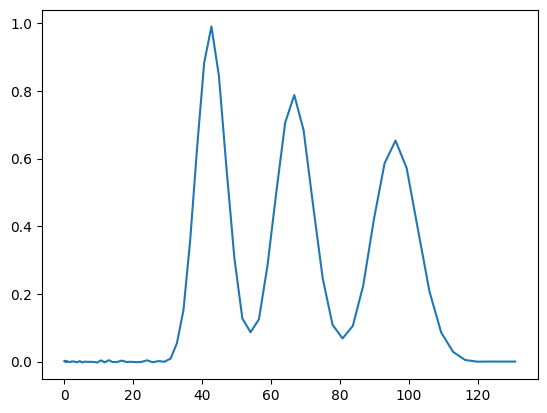

In [9]:
# plot the energy distribution (For example, observing I⁺ of CH₃I -> CH₃ + I)
m = 127      # the mass of photofragment, I⁺
M = 142      # the mass of parent molecule, CH₃I
Et, IEt = energydist(recons, ppm, tof, N, m, M)  # Et is a vector of center-of-mass kinetic energy release in kJ/mol
plot(Et, IEt)
;

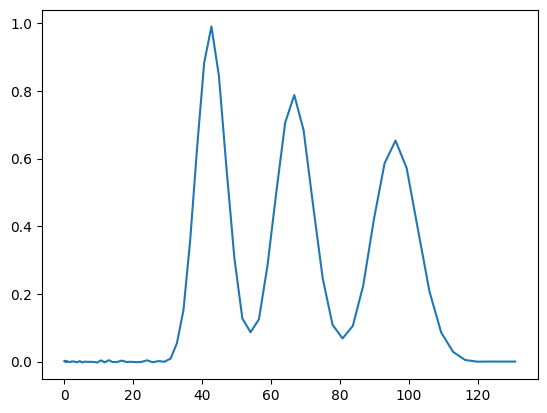

In [10]:
# calculate the energy distribution from the speed distribution
Et, IEt = energydist(v, Iv, m, M)  # Et is a vector of center-of-mass kinetic energy release in kJ/mol
plot(Et, IEt)
;

## Anisotropy parameters v.s. radius (pixel)
Generally, the angular distribution of photofragments/photoelectrons $I(\theta)$ obeys a linear combination of Legendre polynomials $P_{l}$ which $l$ is even. In case of a *n*-photon excitation process, the induced photofragment/photoelectron angular distribution is expressed by the linear combination of $P_{l}$ with these moments $\beta_{l}$, this is called anisotropy parameter, up to $l = 2n$.

$$
I(\theta) \propto 1 + \beta_{2} P_{2}(\cos \theta) + \beta_{4} P_{4}(\cos \theta) + \cdots
$$

Those anisotropy parameters can be obtained to fit the angular distribution and characterizes the original photo-chemical process. The angular distributions are obtained at each radius of an image $I^r(\theta)$; variation of anisotropy parameters may imply different photo-chemical process at each kinetic energy release. Note that the anisotopy parameter may not be meaningful if the corresponding radial distribution is very weak.

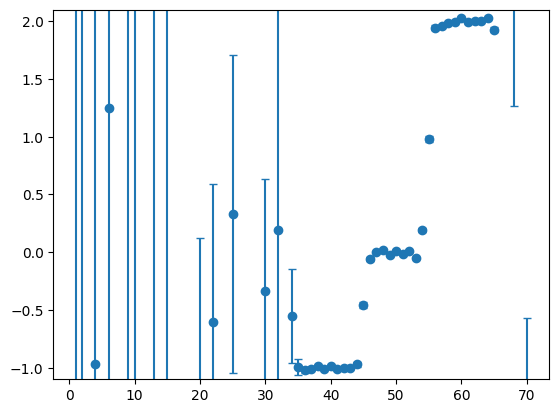

In [11]:
# plot β₂ along the radial axis
r, b, berr = anisotropy(recons)
r = collect(r)
β = b[:, 1]
βerr = berr[:, 1]
errorbar(r, β, βerr, fmt="o", capsize=3)
ylim([-1.1, 2.1])
;

## Anisotropy parameters v.s. fragment recoiling speed (m/s)

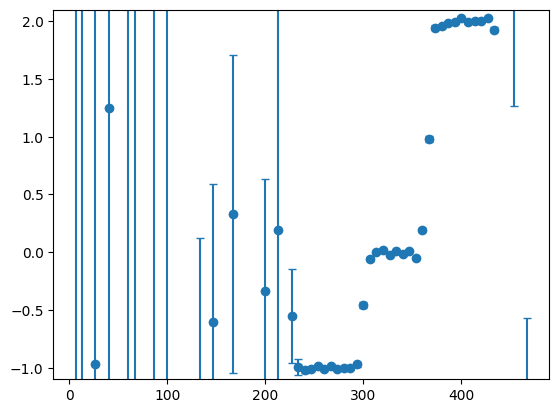

In [12]:
# plot β₂ along the speed axis
# NOTE that the β₂ may not be reasonable if the corresponding radial distribution is too weak
ppm = 10e3   # pixel-per-meter (px/m)
tof = 10e-6  # time-of-flight in second
N   = 1.5    # magnification factor
v, _ = speeddist(recons, ppm, tof, N)
_, b, berr = anisotropy(recons)
β = b[:, 1]
βerr = berr[:, 1]
errorbar(v, β, βerr, fmt="o", capsize=3)
ylim([-1.1, 2.1])
;

## Anisotropy parameters v.s. total kinetic energy release (kJ/mol)

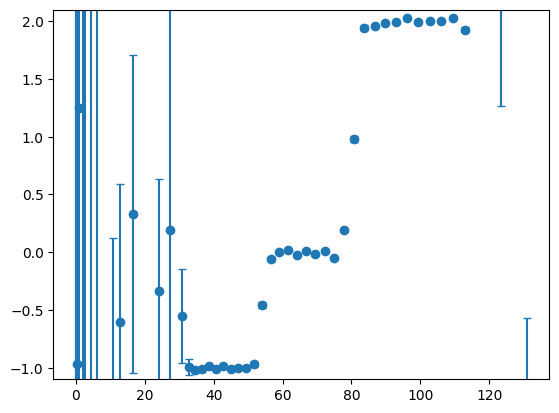

In [13]:
# plot β₂ along the energy axis
m = 127      # the mass of photofragment
M = 142      # the mass of parent molecule
Et, _ = energydist(recons, ppm, tof, N, m, M)
_, b, berr = anisotropy(recons)
β = b[:, 1]
βerr = berr[:, 1]
errorbar(Et, β, βerr, fmt="o", capsize=3)
ylim([-1.1, 2.1])
;

## Hide data points with large standard deviation

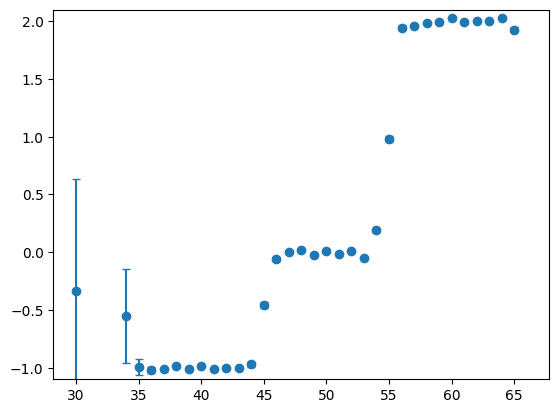

In [14]:
# plot β₂ along the radial axis
r, b, berr = anisotropy(recons)
r = collect(r)
b[berr .> 1.0] .= NaN
β = b[:, 1]
βerr = berr[:, 1]
errorbar(r, β, βerr, fmt="o", capsize=3)
ylim([-1.1, 2.1])
;

## Handle low quality images
In real, experimental images are sometimes weak and/or noisy, and may result in the messy data. To avoid this problem, user should preprocess the images before reconstruction for better results. Smoothing is one of good choices in many cases. `smooth(img, σ)` function is useful for the purpose, it process the image `img` with an average filter of size `σ x σ`. Other than the `smooth`, `imfilter` function provided by [ImageFiltering.jl package](https://github.com/JuliaImages/ImageFiltering.jl) will be useful for the use of more various filters.

**Note** that smoothing sacrifices the image resolution, determine the size of filter with care.

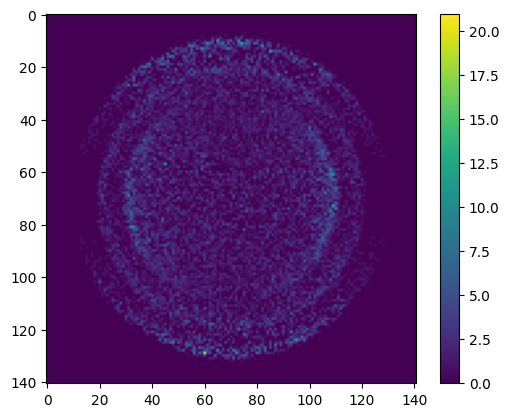

In [15]:
# load a low quality image
#   Arc1: r = 40 px, σ = 1, β = -1
#   Arc2: r = 50 px, σ = 1, β = 0
#   Arc3: r = 60 px, σ = 1, β = 2
lowq = readdlm("test\\test03.tsv")
imshow(lowq)
colorbar()
;

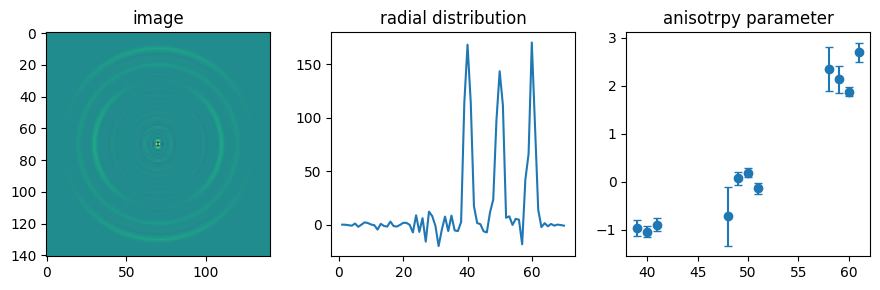

In [16]:
# Both the radial distribution and anisotropy parameters are noisy without smoothing
recons = pbasex(lowq, (71, 71))
r, Ir = radialdist(recons)
_, b, berr = anisotropy(recons)
r = collect(r)
b[berr .> 1.0] .= NaN
β = b[:, 1]
βerr = berr[:, 1]

fig = figure(figsize=(9,3))
ax1 = fig.add_subplot(131)
ax1.imshow(Array(recons))
ax1.set_title("image")
ax2 = fig.add_subplot(132)
ax2.plot(r, Ir)
ax2.set_title("radial distribution")
ax3 = fig.add_subplot(133)
ax3.errorbar(r, β, βerr, fmt="o", capsize=3)
ax3.set_title("anisotrpy parameter")
tight_layout()
;

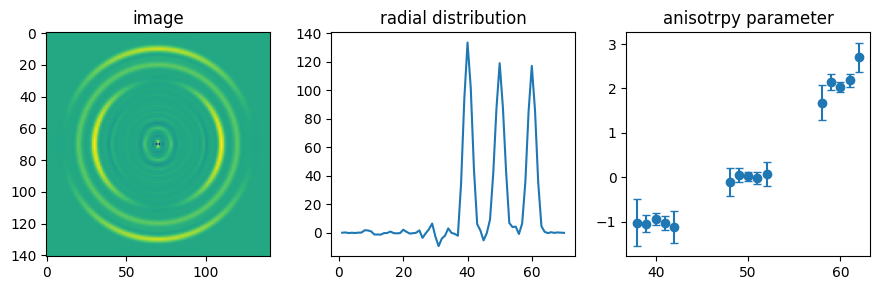

In [17]:
# smoothing makes these results better
# smooth(image, 3) apply 3x3 averaging filter to the image
smoothed = smooth(lowq, 3)

recons = pbasex(smoothed, (71, 71))
r, Ir = radialdist(recons)
_, b, berr = anisotropy(recons)
r = collect(r)
b[berr .> 1.0] .= NaN
β = b[:, 1]
βerr = berr[:, 1]

fig = figure(figsize=(9,3))
ax1 = fig.add_subplot(131)
ax1.imshow(Array(recons))
ax1.set_title("image")
ax2 = fig.add_subplot(132)
ax2.plot(r, Ir)
ax2.set_title("radial distribution")
ax3 = fig.add_subplot(133)
ax3.errorbar(r, β, βerr, fmt="o", capsize=3)
ax3.set_title("anisotrpy parameter")
tight_layout()
;

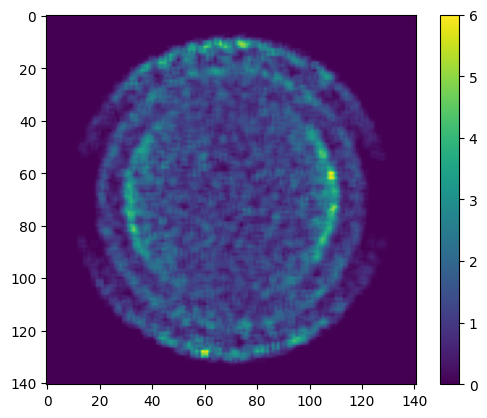

In [18]:
# smoothed image
smoothed = smooth(lowq, 3)
imshow(smoothed)
colorbar()
;

## Counter-measure for the noise at the center
Typically, pBasex algorithm concentrates the noise at the center (r ~ 0), instead of the center line (x ~ 0) which is often shown by naive inverse Abel transform or Basex algorithm. [3] The strong noise often makes the image plot unclear, user may need to edit the image or to optimize plot function appropriately for better presence.

[3] Dribinski, V.; Ossadtchi, A.; Mandelshtam, V. A.; Reisler, H. Reconstruction of Abel-Transformable Images: The Gaussian Basis-Set Expansion Abel Transform Method. *Rev. Sci. Instrum.* **2002**, *73*, 2634-2642.

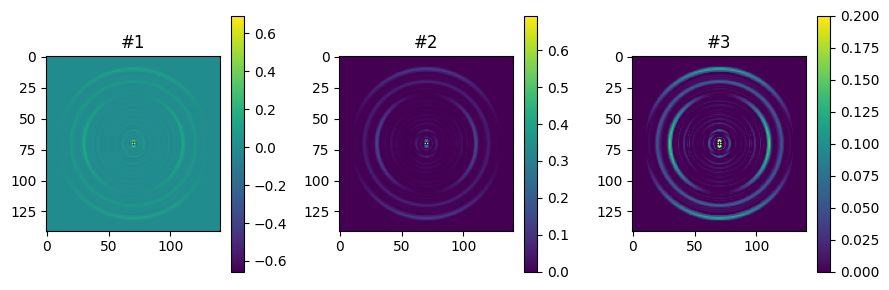

In [19]:
recons = pbasex(lowq, (71, 71))
fig = figure(figsize=(9,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# 1. as it is
# inverted image may have strong noise at the center
noisy = Array(recons)
img1 = ax1.imshow(noisy)
colorbar(img1, ax=ax1)
ax1.set_title("#1")

# 2. suppress negative pixels
# force set zero if signal is less than zero
suppressed = copy(noisy)
suppressed[noisy .< 0] .= 0
img2 = ax2.imshow(suppressed)
colorbar(img2, ax=ax2)
ax2.set_title("#2")

# 3. adjust shown color range
# do not edit the matrix, optimize the plot function (imshow)
img3 = ax3.imshow(noisy, vmin=0.0, vmax=0.2)
colorbar(img3, ax=ax3)
ax3.set_title("#3")

tight_layout()
;

## Higher order terms of anisotropy parameters
`PBasex` function accepts a keyword argument `l` to specify the order of Legendre polynomials including in the basis set matrix. For example, `PBasex(len, l=[1, 2, 3, 4])` makes a reconstructor to fit its angular distributions with:

$$
I(\theta) = B \left[ 1 + \beta_{1} P_{1}(\cos \theta) + \beta_{2} P_{2}(\cos \theta) + \beta_{3} P_{3}(\cos \theta) + \beta_{4} P_{4}(\cos \theta) \right]
$$

where $B$ is a proportionality factor. If `l` keyword is omitted, only the second order term is taken into account (`l = [2]`) in default, which is reasonable for the analysis of one-photon excitation process.

Computing basis set...100%|█████████████████████████████| Time: 0:00:01


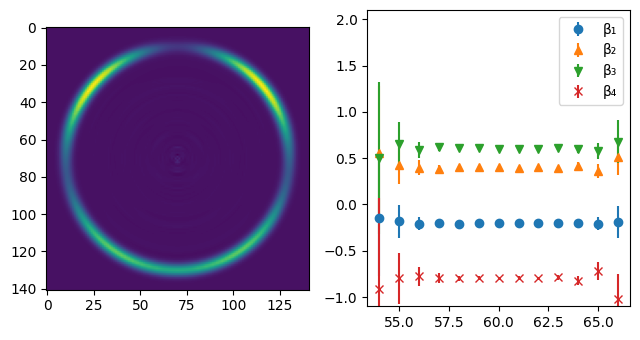

l = [1, 2, 3, 4]


In [20]:
# image with
#   β₁ = -0.2
#   β₂ =  0.4
#   β₃ =  0.6
#   β₄ = -0.8
# at r ~ 60
img = readdlm("test\\test04.tsv")
fig = figure(figsize=(6.5, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# specify the vector of l to include
pbasex = PBasex(141, l=[1, 2, 3, 4])
recons = pbasex(img, (71, 71))

ax1.imshow(Array(recons))

# NOTE: l is automatically sorted
r, b, berr, l = anisotropy(recons)
@show l

r = collect(r)
marker = ["o", "^", "v", "x"]
subscript = ["₁", "₂", "₃", "₄"]
b[berr .> 1.0] .= NaN
for (i, l) in enumerate(l)
    ax2.errorbar(r, b[:, i], berr[:, i], fmt=marker[i], label="β"*subscript[i])
end
ax2.legend()
ax2.set_ylim([-1.1, 2.1])
fig.tight_layout()
;